In [9]:
import json
import gc
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from tqdm import tqdm
from honeybee.models import RadImageNet
from honeybee.loaders import Scan
import torch
import os
import minds
from huggingface_hub import HfApi

In [ ]:
PROJECTS = [
    "CPTAC-2",
    "CPTAC-3",
]
RADIOLOGY_MODALITIES = [
    "MG",
    "CT",
    "MR",
    "SEG",
    "RTSTRUCT",
    "CR",
    "SR",
    "US",
    "PT",
    "DX",
    "RTDOSE",
    "RTPLAN",
    "PR",
    "REG",
    "RWV",
    "NM",
    "KO",
    "FUSION",
    "XA",
    "OT",
    "SC",
    "RF",
]

for PROJECT in PROJECTS:
    DATA_DIR = f"/mnt/d/CPTAC/raw/{PROJECT}"
    MANIFEST_PATH = f"{DATA_DIR}/manifest.json"
    cptac_cohort = minds.build_cohort(
        output_dir=DATA_DIR,
        query=f"SELECT * FROM minds.clinical WHERE project_id = '{PROJECT}'",
        manifest=MANIFEST_PATH if os.path.exists(MANIFEST_PATH) else None,
    )
    cptac_cohort.stats()
    # cptac_cohort.download(threads=8, include=RADIOLOGY_MODALITIES)

In [ ]:
def manifest_to_df(manifest_path, modality):
    with open(manifest_path, "r") as f:
        manifest = json.load(f)
    modality_df = pd.DataFrame()
    for patient in manifest:
        patient_id = patient["PatientID"]
        gdc_case_id = patient["gdc_case_id"] if "gdc_case_id" in patient else None
        if modality in patient:
            df = pd.DataFrame(patient[modality])
            df["PatientID"] = patient_id
            df["gdc_case_id"] = gdc_case_id if gdc_case_id is not None else patient_id
            modality_df = pd.concat([modality_df, df], ignore_index=True)
    return modality_df if not modality_df.empty else None


radimagenet = RadImageNet("/mnt/d/Models/radimage/DenseNet121.pt")

for PROJECT in PROJECTS:
    DATA_DIR = f"/mnt/d/CPTAC/raw/{PROJECT}"
    MANIFEST_PATH = f"{DATA_DIR}/manifest.json"

    with open(MANIFEST_PATH, "r") as f:
        manifest = json.load(f)

    print(manifest[0].keys())

    radiology_modalities = {
        modality
        for patient in manifest
        for modality in RADIOLOGY_MODALITIES
        if modality in patient
    }

    for modality in radiology_modalities:
        PARQUET = (
            f"/mnt/d/CPTAC/parquet/{PROJECT} {modality} Radiology (RadImageNet).parquet"
        )
        # Ensure the directory for the Parquet file exists
        os.makedirs(os.path.dirname(PARQUET), exist_ok=True)

        df = manifest_to_df(MANIFEST_PATH, modality)
        if df is None:
            continue

        schema = pa.schema(
            [
                ("StudyInstanceUID", pa.string()),
                ("SeriesInstanceUID", pa.string()),
                ("SeriesDate", pa.string()),
                ("BodyPartExamined", pa.string()),
                ("SeriesNumber", pa.string()),
                ("Collection", pa.string()),
                ("Manufacturer", pa.string()),
                ("ManufacturerModelName", pa.string()),
                ("SoftwareVersions", pa.string()),
                ("Visibility", pa.string()),
                ("ImageCount", pa.int64()),
                ("PatientID", pa.string()),
                ("gdc_case_id", pa.string()),
                ("ProtocolName", pa.string()),
                ("SeriesDescription", pa.string()),
                ("embedding", pa.binary()),
                ("embedding_shape", pa.list_(pa.int64())),
                ("__index_level_0__", pa.int64()),
            ]
        )

        # Ensure all required columns are present in the DataFrame
        for col in schema.names:
            if col not in df.columns:
                df[col] = None

        df["embedding"] = None
        df["embedding_shape"] = None

        if os.path.exists(PARQUET):
            # If the Parquet file exists, read it into a DataFrame
            existing_df = pq.read_table(PARQUET).to_pandas()
            # Concatenate the new data with the existing data
            df = pd.concat([existing_df, df], ignore_index=True)

        writer = pq.ParquetWriter(PARQUET, schema)

        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
            embedding = None  # Initialize embedding before the try block
            patches = None  # Initialize patches before the try block
            try:
                file_path = f"{DATA_DIR}/raw/{row['PatientID']}/{modality}/{row['SeriesInstanceUID']}/{row['SeriesInstanceUID']}"
                scanner = Scan(file_path)
                patches = scanner.load_patches(target_patch_size=224)
                patches = patches.transpose((0, 3, 1, 2))
                patches = torch.from_numpy(patches).float().cuda()
                embedding = radimagenet.load_model_and_predict(patches)
                embedding = embedding.cpu().detach().numpy()
                df.at[index, "embedding_shape"] = embedding.shape
                df.at[index, "embedding"] = embedding.tobytes()
            except Exception as e:
                print(f"Error: {e}")
                df.at[index, "embedding"] = None

            table = pa.Table.from_pandas(df.iloc[[index]], schema=schema)
            writer.write_table(table)

            del scanner, patches, embedding, table
            gc.collect()
            torch.cuda.empty_cache()

        if writer is not None:
            writer.close()

In [4]:
def combine_parquet_files(output_file):
    all_dfs = []
    parquet_dir = "/mnt/d/CPTAC/parquet"

    for root, _, files in os.walk(parquet_dir):
        for file in tqdm(
            files, desc="Reading files", total=len(files), unit="files", leave=False
        ):
            if file.endswith("Radiology (RadImageNet).parquet"):
                file_path = os.path.join(root, file)
                df = pq.read_table(file_path).to_pandas()
                all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_table = pa.Table.from_pandas(combined_df)
    pq.write_table(combined_table, output_file)


combine_parquet_files("/mnt/d/CPTAC/parquet/Radiology (RadImageNet).parquet")

In [6]:
# make a copy of the "/mnt/d/CPTAC/parquet/Radiology (RadImageNet).parquet" file at "/mnt/d/CPTAC/parquet/Radiology (RadImageNet)/Radiology (RadImageNet).parquet"
! mkdir "/mnt/d/CPTAC/parquet/Radiology (RadImageNet)"
! cp "/mnt/d/CPTAC/parquet/Radiology (RadImageNet).parquet" "/mnt/d/CPTAC/parquet/Radiology (RadImageNet)/Radiology (RadImageNet).parquet"

In [7]:
program = "CPTAC"
api = HfApi()
api.upload_folder(
    folder_path=f"/mnt/d/{program}/parquet/Radiology (RadImageNet)",
    path_in_repo="Radiology (RadImageNet)",
    repo_id=f"Lab-Rasool/{program}",
    repo_type="dataset",
    multi_commits=True,
    multi_commits_verbose=True,
)

/home/aakash/miniconda3/envs/honeybee/lib/python3.11/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'plan_multi_commits' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
/home/aakash/miniconda3/envs/honeybee/lib/python3.11/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'HfApi.create_commits_on_pr' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
Will create 0 deletion commit(s) and 1 addition commit(s), totalling 1 atomic operations.
INFO:huggingface_hub.hf_api.create_commits_on_pr:Will create 0 deletion commit(s) and 1 addition commit(s), totalling 1 atomic operations.
Multi-commits strategy with ID e9fe314c1e35b9fb6b6c5717060ffd6db5e0372105a320176d03cd8a

Radiology (RadImageNet).parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

  step 00935aa34357658645bd0f0b2cfaeee74eb6c0996d4d84eeec8ee890f9910419 completed (still 0 to go).
INFO:huggingface_hub.hf_api.create_commits_on_pr:  step 00935aa34357658645bd0f0b2cfaeee74eb6c0996d4d84eeec8ee890f9910419 completed (still 0 to go).
All commits have been pushed.
INFO:huggingface_hub.hf_api.create_commits_on_pr:All commits have been pushed.
PR is now open for reviews.
INFO:huggingface_hub.hf_api.create_commits_on_pr:PR is now open for reviews.
PR has been automatically merged (`merge_pr=True` was passed).
INFO:huggingface_hub.hf_api.create_commits_on_pr:PR has been automatically merged (`merge_pr=True` was passed).


'https://huggingface.co/datasets/Lab-Rasool/CPTAC/discussions/2'

In [18]:
from datasets import load_dataset
import os
from torch.utils.data import Dataset
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        hf_item = self.hf_dataset[idx]
        embedding = np.frombuffer(hf_item["embedding"], dtype=np.float32)
        embedding_shape = hf_item["embedding_shape"]
        embedding = embedding.reshape(embedding_shape)
        return embedding


if __name__ == "__main__":
    clinical_dataset = load_dataset("Lab-Rasool/CPTAC", "clinical", split="gatortron")
    rad_dataset = load_dataset("Lab-Rasool/CPTAC", "radiology", split="radimagenet")

    failed_indices = []
    fail_count = 0
    for index, item in enumerate(rad_dataset):
        if item.get("embedding") is not None:
            print(
                index,
                np.frombuffer(item.get("embedding"), dtype=np.float32)
                .reshape(item.get("embedding_shape"))
                .shape,
            )
        else:
            failed_indices.append(index)
            fail_count += 1

0 (1, 1000)
1 (1, 1000)
2 (1, 1000)
3 (1, 1000)
4 (1, 1000)
5 (1, 1000)
6 (1, 1000)
7 (1, 1000)
8 (1, 1000)
9 (1, 1000)
10 (1, 1000)
11 (1, 1000)
12 (1, 1000)
13 (1, 1000)
14 (1, 1000)
15 (1, 1000)
16 (1, 1000)
17 (1, 1000)
18 (1, 1000)
19 (1, 1000)
20 (232, 1000)
21 (1, 1000)
22 (1, 1000)
23 (1, 1000)
24 (1, 1000)
25 (1, 1000)
26 (1, 1000)
27 (1, 1000)
28 (1, 1000)
29 (1, 1000)
30 (1, 1000)
31 (1, 1000)
32 (1, 1000)
35 (1, 1000)
37 (1, 1000)
38 (1, 1000)
39 (1, 1000)
42 (1, 1000)
44 (1, 1000)
74 (1, 1000)
75 (1, 1000)
76 (1, 1000)
77 (1, 1000)
78 (1, 1000)
79 (1, 1000)
80 (1, 1000)
81 (1, 1000)
82 (1, 1000)
83 (1, 1000)
84 (1, 1000)
85 (1, 1000)
86 (1, 1000)
87 (1, 1000)
88 (1, 1000)
89 (1, 1000)
90 (1, 1000)
91 (9, 1000)
92 (1, 1000)
93 (1, 1000)
94 (1, 1000)
95 (1, 1000)
96 (1, 1000)
97 (1, 1000)
98 (1, 1000)
99 (1, 1000)
100 (1, 1000)
101 (158, 1000)
102 (158, 1000)
103 (158, 1000)
104 (158, 1000)
105 (158, 1000)
106 (1, 1000)
107 (158, 1000)
108 (1, 1000)
109 (1, 1000)
110 (1, 100

Failed to load embeddings for 6012 items.
Failed indices: [33, 34, 36, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 210, 212, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 392, 394, 426, 428, 436, 437, 438, 440, 498, 501, 502, 503, 511, 514, 517, 519, 524, 525, 526, 527, 557, 561, 564, 566, 568, 571, 584, 586, 587, 593, 596, 598, 600, 603, 606, 607, 608, 611, 612, 614, 615, 616, 619, 620, 632, 634, 635, 638, 640, 643, 644, 648, 654, 657, 659, 660, 664, 693, 695, 697, 699, 711, 713, 714, 717, 735, 739, 755, 757, 759, 763, 766, 767, 778, 784, 785, 786, 810, 811, 837, 838, 839, 913, 929, 934, 939, 940, 941, 943, 948, 952, 954, 959, 961, 968, 1047, 1048, 1049, 105

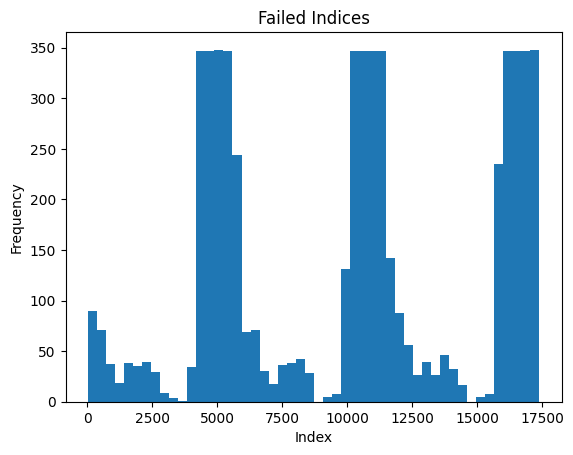

In [19]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Failed to load embeddings for {fail_count} items.")
print(f"Failed indices: {failed_indices}")

# plot the failed indices as a histogram
plt.hist(failed_indices, bins=50)
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Failed Indices")
plt.show()